In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import json
from dotenv import load_dotenv
import os
load_dotenv()

True

In [16]:
api_key = os.getenv("EIA_API_KEY")

if not api_key:
    raise ValueError("API key not found in .env file.")

# Setup for the API call 
api_url = "https://api.eia.gov/v2/electricity/rto/region-data/data/"
all_data = []
offset = 0
length = 5000 # The number of records to get per request

while True:
    params = {
        "api_key": api_key,
        "frequency": "hourly",
        "data[0]": "value",

        # Filter for specific regions
        "facets[respondent][]": ["CISO", "PJM", "ERCO"], # California, Mid-Atlantic, Texas
        
        "start": "2025-01-01T00",
        "end": "2025-08-18T00",
        "sort[0][column]": "period",
        "sort[0][direction]": "desc",
        "offset": offset,
        "length": length
    }

    print(f"Fetching records from offset: {offset}...")
    response = requests.get(api_url, params=params)

    if response.status_code == 200:
        data = response.json()
        records = data['response']['data']
        
        if not records:
            print("No more records to fetch. Loop finished.")
            break
        
        all_data.extend(records)
        offset += length # Increasing the offset for the next page
        
    else:
        print(f"Failed to retrieve data. Status code: {response.status_code}")
        print(response.text)
        break

# Convert the final list of all data into a DataFrame
df = pd.DataFrame(all_data)

print("\n------------------------------------------")
print(f"Data loading complete! Total records fetched: {len(df)}")
df.info()


Fetching records from offset: 0...
Fetching records from offset: 5000...
Fetching records from offset: 10000...
Fetching records from offset: 15000...
Fetching records from offset: 20000...
Fetching records from offset: 25000...
Fetching records from offset: 30000...
Fetching records from offset: 35000...
Fetching records from offset: 40000...
Fetching records from offset: 45000...
Fetching records from offset: 50000...
Fetching records from offset: 55000...
Fetching records from offset: 60000...
Fetching records from offset: 65000...
Fetching records from offset: 70000...
No more records to fetch. Loop finished.

------------------------------------------
Data loading complete! Total records fetched: 65491
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65491 entries, 0 to 65490
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   period           65491 non-null  object
 1   respondent       65491 non-null  ob

In [17]:
# Save to CSV 
df.to_csv("Electricity.csv", index=False)
print("Data saved to Electricity.csv")

Data saved to Electricity.csv


In [67]:
#working locally
df = pd.read_csv("Electricity.csv")

In [68]:
df.head()  

,period,respondent,respondent-name,type,type-name,value,value-units
0,2025-08-17T07,CISO,California Independent System Operator,DF,Day-ahead demand forecast,26249,megawatthours
1,2025-08-17T06,CISO,California Independent System Operator,DF,Day-ahead demand forecast,27914,megawatthours
2,2025-08-17T05,CISO,California Independent System Operator,DF,Day-ahead demand forecast,29457,megawatthours
3,2025-08-17T05,ERCO,"Electric Reliability Council of Texas, Inc.",DF,Day-ahead demand forecast,64069,megawatthours
4,2025-08-17T04,CISO,California Independent System Operator,DF,Day-ahead demand forecast,30347,megawatthours


In [69]:
# Count duplicate rows
num_duplicates = df.duplicated().sum()
print(f"Number of duplicate rows: {num_duplicates}")

# Count missing values per column
missing_per_column = df.isnull().sum()
print("Missing values per column:")
print(missing_per_column)

# Total missing values in the entire DataFrame
total_missing = df.isnull().sum().sum()
print(f"Total missing values in the dataset: {total_missing}")


Number of duplicate rows: 0
Missing values per column:
period             0
respondent         0
respondent-name    0
type               0
type-name          0
value              0
value-units        0
dtype: int64
Total missing values in the dataset: 0


In [70]:
# Checking if the 'period' column has timezone information
if pd.to_datetime(df['period']).dt.tz is not None:
    print("The 'period' column is already timezone-aware.")
else:
    print("The 'period' column is timezone-naive.")


The 'period' column is timezone-naive.


In [71]:
# Robustly Handling the 'period' column's timezone

# First, ensuring the column is a datetime object
df['period'] = pd.to_datetime(df['period'])

# Checking if the datetime object is already timezone-aware
if df['period'].dt.tz is not None:
    # If it is, CONVERT it to UTC
    print("Column is already timezone-aware. Converting to UTC...")
    df['period'] = df['period'].dt.tz_convert('UTC')
else:
    # If it's naive (no timezone), LOCALIZE it to UTC
    print("Column is timezone-naive. Localizing to UTC...")
    df['period'] = df['period'].dt.tz_localize('UTC')


# Defining the correct local time zones
tz_map = {
    'CISO': 'America/Los_Angeles', # Pacific Time
    'ERCO': 'America/Chicago',     # Central Time
    'PJM':  'America/New_York'     # Eastern Time
}

# Creating the 'period_local' column 
df['period_local'] = df.apply(
    lambda row: row['period'].tz_convert(tz_map.get(row['respondent'], 'UTC')),
    axis=1
)

# Explicitly converting the new column to a datetime format 
df['period_local'] = pd.to_datetime(df['period_local'])

# Creating the final analysis columns
df['local_hour'] = df['period_local'].dt.hour
df['local_day_of_week'] = df['period_local'].dt.day_name()
df['local_month'] = df['period_local'].dt.month

# Displaying the result
print("\nTime conversion complete. Here are the new columns:")
df[['period', 'period_local', 'local_hour', 'local_day_of_week']].head()

Column is timezone-naive. Localizing to UTC...

Time conversion complete. Here are the new columns:


,period,period_local,local_hour,local_day_of_week
0,2025-08-17 07:00:00+00:00,2025-08-17 00:00:00-07:00,0,Sunday
1,2025-08-17 06:00:00+00:00,2025-08-16 23:00:00-07:00,23,Saturday
2,2025-08-17 05:00:00+00:00,2025-08-16 22:00:00-07:00,22,Saturday
3,2025-08-17 05:00:00+00:00,2025-08-16 22:00:00-07:00,22,Saturday
4,2025-08-17 04:00:00+00:00,2025-08-16 21:00:00-07:00,21,Saturday


In [72]:
df.sample(5)

,period,respondent,respondent-name,type,type-name,value,value-units,period_local,local_hour,local_day_of_week,local_month
33918,2025-04-20 18:00:00+00:00,CISO,California Independent System Operator,D,Demand,20570,megawatthours,2025-04-20 11:00:00-07:00,11,Sunday,4
64925,2025-01-02 23:00:00+00:00,PJM,"PJM Interconnection, LLC",NG,Net generation,111690,megawatthours,2025-01-02 15:00:00-08:00,15,Thursday,1
48111,2025-03-02 08:00:00+00:00,PJM,"PJM Interconnection, LLC",D,Demand,94726,megawatthours,2025-03-02 00:00:00-08:00,0,Sunday,3
62065,2025-01-12 21:00:00+00:00,ERCO,"Electric Reliability Council of Texas, Inc.",NG,Net generation,47958,megawatthours,2025-01-12 13:00:00-08:00,13,Sunday,1
864,2025-08-13 13:00:00+00:00,ERCO,"Electric Reliability Council of Texas, Inc.",NG,Net generation,56467,megawatthours,2025-08-13 06:00:00-07:00,6,Wednesday,8


In [73]:
# creating a DataFrame of only the negative values
negative_values_df = df[df['value'] < 0]

# getting a count of which data types they belong to
print("Categories containing negative values:")
print(negative_values_df['type-name'].value_counts())

print("\n-------------------------------------\n")

# For comparison, let's see the categories for positive values
positive_values_df = df[df['value'] >= 0]
print("Categories containing positive values:")
print(positive_values_df['type-name'].value_counts())

Categories containing negative values:
type-name
Total interchange    7804
Name: count, dtype: int64

-------------------------------------

Categories containing positive values:
type-name
Day-ahead demand forecast    16412
Demand                       16383
Net generation               16360
Total interchange             8532
Name: count, dtype: int64


# Daily Cycle Analysis

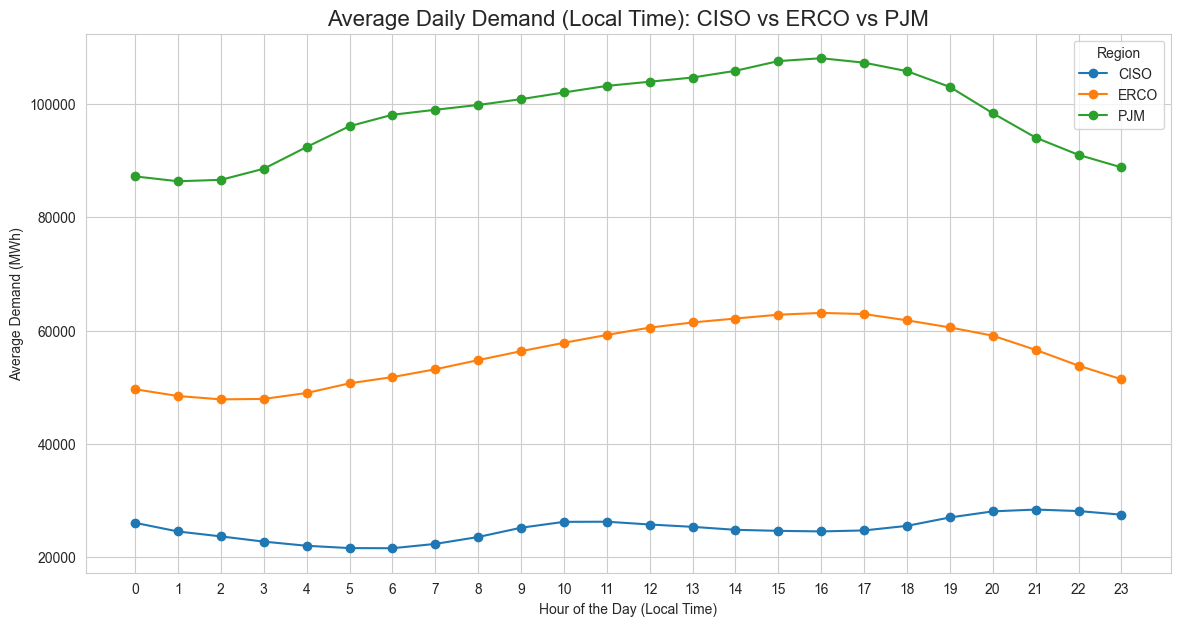

In [74]:
# Setting the plot style
sns.set_style("whitegrid")

# Filtering for just the 'Demand' data
demand_df = df[df['type-name'] == 'Demand']

# Grouping by respondent and the correct 'local_hour' column
hourly_demand_by_region = demand_df.groupby(['respondent', 'local_hour'])['value'].mean()

# Restructuring the data for plotting (regions as columns)
comparison_plot_df = hourly_demand_by_region.unstack(level='respondent')

# Creating the plot
plt.figure(figsize=(14, 7))
comparison_plot_df.plot(ax=plt.gca(), marker='o', linestyle='-')

plt.title('Average Daily Demand (Local Time): CISO vs ERCO vs PJM', fontsize=16)
plt.xlabel('Hour of the Day (Local Time)')
plt.ylabel('Average Demand (MWh)')
plt.xticks(range(0, 24))
plt.legend(title='Region')
plt.grid(True)
plt.show()

## Key Insights
##### Consistent Evening Peak:
The plot clearly shows that for all three major regions, the highest electricity demand consistently occurs in the late afternoon and early evening, generally between 4 PM and 7 PM. This is a predictable daily pattern driven by residential activity as the workday ends.

##### Different Morning "Ramps": 
The speed at which demand increases in the morning varies by region. PJM shows a particularly steep climb starting around 5 AM, which reflects a massive, synchronized start to the business day across its dense metropolitan areas.

##### Sustained Afternoon Demand: 
Both ERCO (Texas) and PJM exhibit a very broad and sustained peak that remains high for several hours. This is a classic signature of regions with significant air conditioning load, where cooling systems run continuously through the afternoon and well into the evening to combat high temperatures.


## Actionable Decisions
### Based on these insights, a grid operator or utility company can make several high-impact decisions:

### 1 - Optimize Power Plant Scheduling:

Action: Knowing the precise timing of the evening peak allows operators to schedule their expensive, fast-reacting "peaker" plants to start generating power only when needed (e.g., starting at 3 PM) and shut them down as demand falls (e.g., after 9 PM). This precise scheduling saves millions in fuel costs by not running costly plants unnecessarily.

### 2 - Ensure Grid Stability:

Action: For a region like CISO (California), which relies heavily on solar power, this chart is critical. Solar production drops sharply just as this evening demand ramp begins. Knowing the exact timing of the ramp allows operators to proactively bring other power sources online or import power to prevent blackouts, a phenomenon famously known as the "duck curve."

### 3 - Design Targeted Customer Programs:

Action: This data provides the evidence needed to design effective "Time-of-Use" pricing plans. Companies can offer customers significant discounts for using electricity during "off-peak" hours (e.g., after 10 PM). This incentivizes consumers to shift heavy loads, like charging electric vehicles or running dishwashers, to times when the grid has plenty of spare capacity, reducing overall strain.

________________________________________________________________________________________________________________________________________________________

# Seasonal Analysis (Winter vs Summer)

C:\Users\yahyafawzey\AppData\Local\Temp\ipykernel_19032\3448833090.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  demand_df['season'] = demand_df['local_month'].apply(get_season)


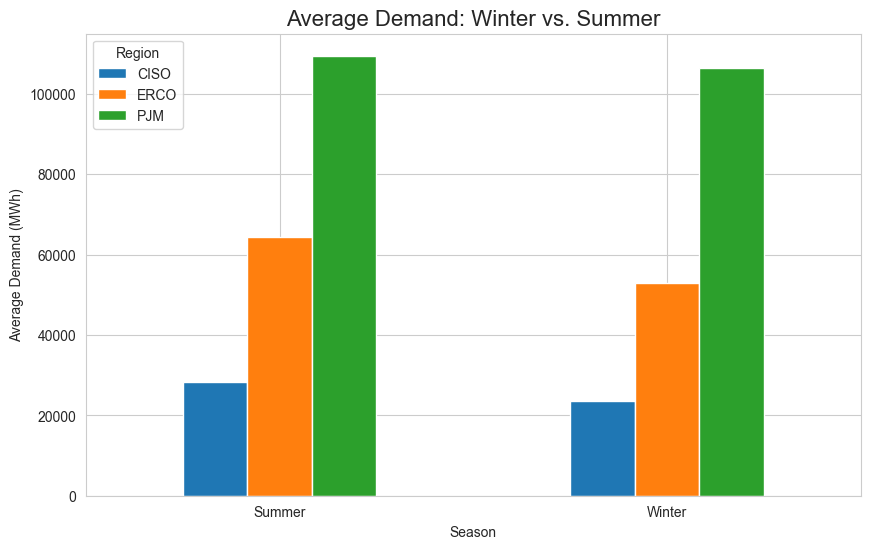

In [75]:
# Defining a function to map month to season BASED ON YOUR DATA
def get_season(month):
    
    if month in [1, 2]: # Winter is now only Jan & Feb (because obviously this data is from Jan to Aug...)
        return 'Winter'
    elif month in [6, 7, 8]: # Summer is Jun, Jul, Aug
        return 'Summer'
    else:
        return 'Other'

# Creating a 'season' column
demand_df['season'] = demand_df['local_month'].apply(get_season)

# Filtering for only Winter and Summer
seasonal_df = demand_df[demand_df['season'].isin(['Winter', 'Summer'])]

# Grouping by season and region to get the average demand
seasonal_comparison = seasonal_df.groupby(['season', 'respondent'])['value'].mean().unstack()

# Creating a bar chart
seasonal_comparison.plot(kind='bar', figsize=(10, 6))
plt.title('Average Demand: Winter vs. Summer', fontsize=16)
plt.xlabel('Season')
plt.ylabel('Average Demand (MWh)')
plt.xticks(rotation=0)
plt.legend(title='Region')
plt.show()

## Key Insights
#### ERCO (Texas) and CISO (California) are "Summer-Peaking" Grids: 
For both Texas and California, the average electricity demand is significantly higher in the summer than in the winter. This is the classic signature of a grid whose peak demand is driven primarily by air conditioning load during hot summer months.

#### PJM is a "Dual-Peaking" Grid: 
The most interesting insight is that for PJM (Mid-Atlantic/Midwest), the average demand in winter is almost as high as in the summer. This indicates a "dual-peaking" system, where the grid is stressed by air conditioning in the summer and by electric heating in the winter.

## Actionable Decisions
This seasonal comparison is crucial for long-term strategic planning.

### 1 - Strategic Maintenance Scheduling:

Action: For summer-peaking grids like ERCO and CISO, the most critical time to perform maintenance on power plants and transmission lines is during the milder spring and fall months. This ensures all equipment is at maximum reliability for the high-stress summer season. For a dual-peaking grid like PJM, the maintenance windows are much tighter, and they must plan for two high-stress periods each year.

### 2 - Long-Term Resource Planning:

Action: This data informs what kind of new power plants to build. ERCO and CISO might invest heavily in solar power, as its peak production aligns well with their summer afternoon demand peaks. PJM, on the other hand, needs a reliable, year-round power source that can handle both summer and winter peaks, which might lead them to invest more in natural gas, nuclear power, or large-scale energy storage.

### 3 - Fuel Procurement and Hedging:

Action: Knowing that winter demand is a major factor, PJM's leadership would use this data to secure contracts for natural gas (a common heating fuel) well ahead of the winter season to lock in prices and ensure supply. Texas and California would focus their efforts on ensuring maximum power availability for the summer.
____________________________________________________________________________________________________________________________________________________

# Interchange Analysis (Importer vs. Exporter)

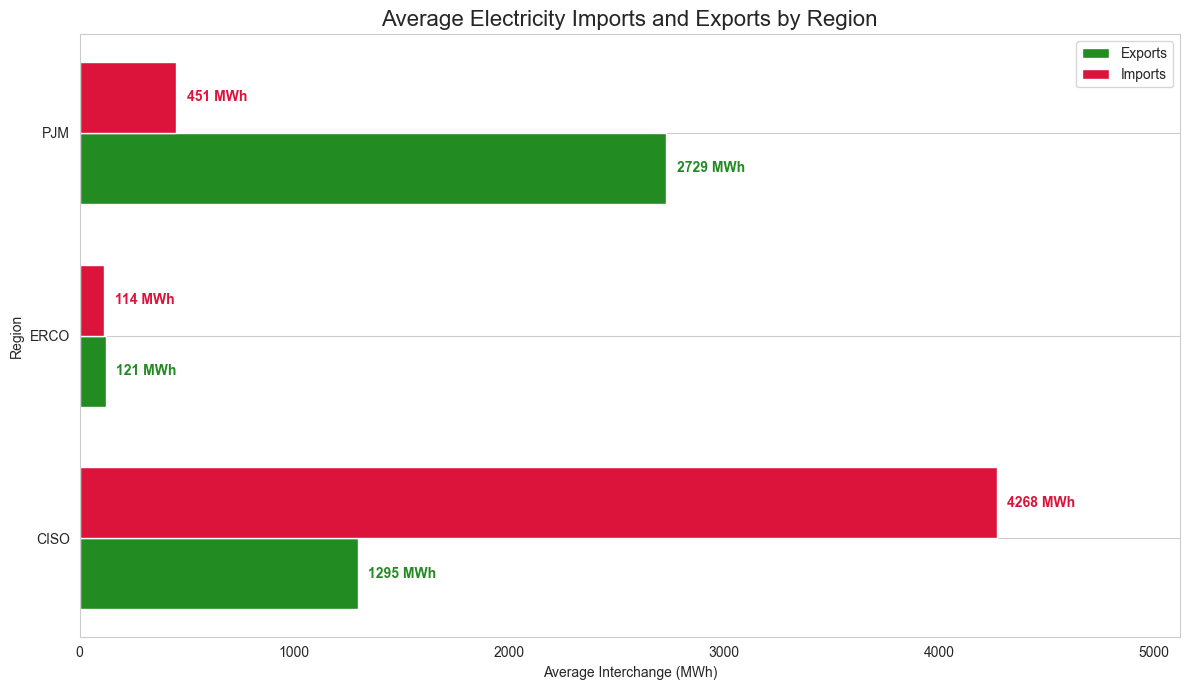

In [76]:
# Data Preparation (same as before)
interchange_df = df[(df['type-name'] == 'Total interchange')]
exports_df = interchange_df[(interchange_df['value'] >= 0)]
imports_df = interchange_df[(interchange_df['value'] < 0)]

avg_exports = exports_df.groupby('respondent')['value'].mean().fillna(0).sort_values(ascending=False)
avg_imports = imports_df.groupby('respondent')['value'].mean().fillna(0).abs().sort_values(ascending=False)

trade_df = pd.DataFrame({'Exports': avg_exports, 'Imports': avg_imports}).fillna(0)

# Plotting 
fig, ax = plt.subplots(figsize=(12, 7))

bar_width = 0.35
y = range(len(trade_df.index))

exports_bars = ax.barh([i - bar_width/2 for i in y], trade_df['Exports'], bar_width, label='Exports', color='forestgreen')
imports_bars = ax.barh([i + bar_width/2 for i in y], trade_df['Imports'], bar_width, label='Imports', color='crimson')

# Adding colored text labels
for bar in exports_bars:
    width = bar.get_width()
    if width > 0:
        ax.text(width + 50, bar.get_y() + bar.get_height()/2.,
                f'{width:.0f} MWh',
                ha='left', va='center', color='forestgreen', fontweight='bold')

for bar in imports_bars:
    width = bar.get_width()
    if width > 0:
        ax.text(width + 50, bar.get_y() + bar.get_height()/2.,
                f'{width:.0f} MWh',
                ha='left', va='center', color='crimson', fontweight='bold')

ax.set_ylabel('Region')
ax.set_xlabel('Average Interchange (MWh)')
ax.set_title('Average Electricity Imports and Exports by Region', fontsize=16)
ax.set_yticks(y)
ax.set_yticklabels(trade_df.index)
ax.legend()
ax.grid(axis='x')

# Adjusting x-axis limits to make space for text
plt.xlim(0, max(trade_df['Exports'].max(), trade_df['Imports'].max()) * 1.2)
plt.tight_layout()
plt.show()

## Key Insights
### 1 - CISO (California) is a Major Net Importer: 
California imports vastly more power (average of 4,268 MWh) than it exports (1,295 MWh). This is a direct consequence of its heavy reliance on solar power. It often produces a surplus of cheap solar energy during the day (which it exports), but in the evening when the sun goes down and demand is still high, it must import large amounts of power from neighboring states.

### 2 - PJM (Mid-Atlantic) is a Powerhouse Exporter: 
The opposite is true for PJM. It exports a huge amount of power (2,729 MWh) while importing very little (451 MWh). This positions PJM as a crucial power provider for the northeastern United States, generating a consistent surplus that it sells to its neighbors.

### 3 - ERCO (Texas) is Remarkably Balanced: 
This chart perfectly visualizes Texas's status as an "energy island." Its average imports (114 MWh) and exports (121 MWh) are nearly identical and are tiny compared to the others. This shows it operates a self-sufficient grid, neither heavily relying on others nor acting as a major supplier.

## Actionable Decisions
This comparative view drives high-level strategic decisions about grid reliability and finances.

### 1 - For CISO (The Importer):

Action: This large import dependency is a significant financial cost and a reliability risk. This data provides the primary justification for investing billions of dollars in large-scale battery storage. The goal is to store California's cheap, excess solar power during the day and release it in the evening, reducing the need to buy expensive power from other states.

### 2 - For PJM (The Exporter):

Action: PJM's status as a net exporter represents a major revenue stream. This data would be used by grid planners to optimize their power plant operations and transmission capacity to maximize these profitable energy sales to neighboring regions, reinforcing their role as a stable power hub.

### 3 - For ERCO (The Balanced Grid):

Action: ERCO's self-sufficiency is a double-edged sword. This chart shows its independence, but it also highlights its vulnerability during extreme events (like a severe winter storm or summer heatwave). Since it can't easily import large amounts of power, any internal failure in generation can lead to blackouts. This data drives policy decisions focused on improving in-state grid resilience and weatherization.
_________________________________________________________________________________________________________________________________________________

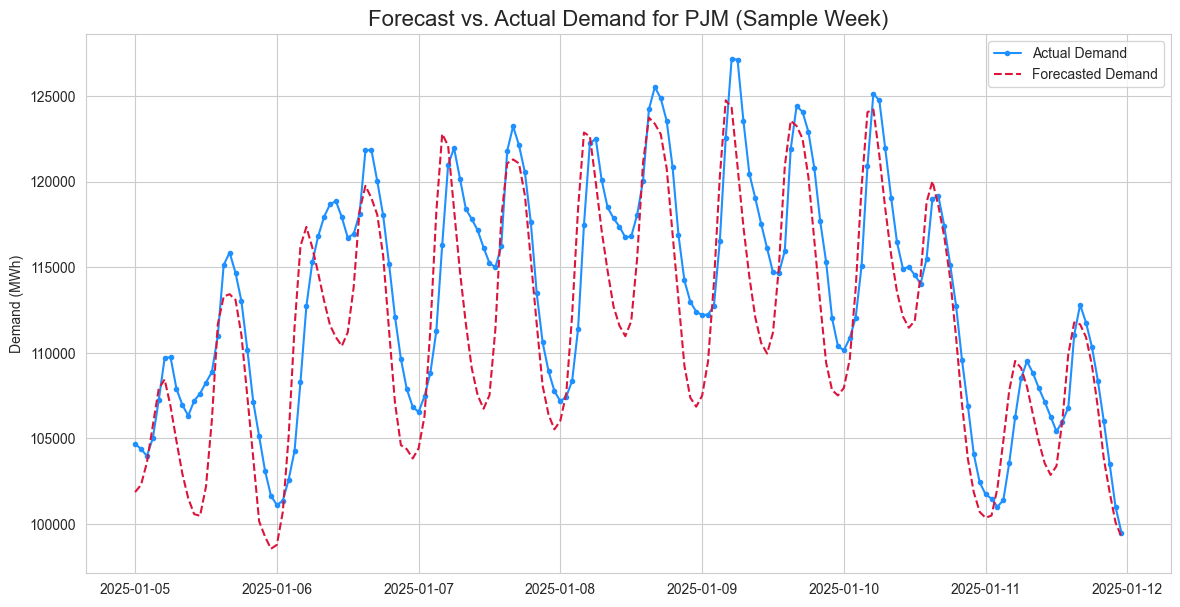

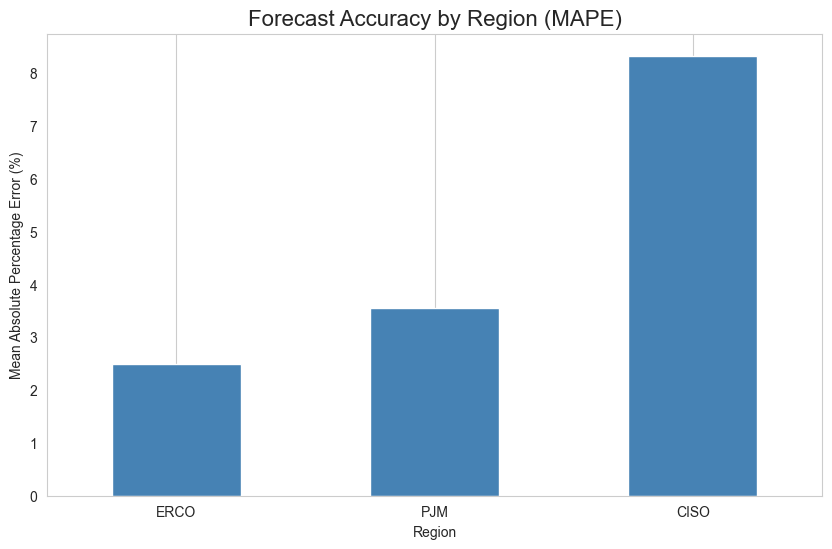

In [77]:
actuals = df[df['type-name'] == 'Demand'][['period_local', 'respondent', 'value']]
actuals = actuals.rename(columns={'value': 'Actual_Demand'})

forecasts = df[df['type-name'] == 'Day-ahead demand forecast'][['period_local', 'respondent', 'value']]
forecasts = forecasts.rename(columns={'value': 'Forecast_Demand'})

comparison_df = pd.merge(actuals, forecasts, on=['period_local', 'respondent'])

# Error Calculation 
comparison_df['abs_percent_error'] = (
    (comparison_df['Actual_Demand'] - comparison_df['Forecast_Demand']).abs() 
    / comparison_df['Actual_Demand']
) * 100

# Visualization 1: Line Chart Comparison (for PJM) 
pjm_sample = comparison_df[comparison_df['respondent'] == 'PJM'].copy()
pjm_sample = pjm_sample.set_index('period_local').sort_index()

# Selecting a sample week from January 2025
pjm_sample_week = pjm_sample.loc['2025-01-05':'2025-01-11']

# Plotting the sample week
plt.figure(figsize=(14, 7))
plt.plot(pjm_sample_week.index, pjm_sample_week['Actual_Demand'], label='Actual Demand', color='dodgerblue', marker='.')
plt.plot(pjm_sample_week.index, pjm_sample_week['Forecast_Demand'], label='Forecasted Demand', color='crimson', linestyle='--')
plt.title('Forecast vs. Actual Demand for PJM (Sample Week)', fontsize=16)
plt.ylabel('Demand (MWh)')
plt.legend()
plt.grid(True)
plt.show()

# Visualization 2: Bar Chart of Average Error by Region 
mape_by_region = comparison_df.groupby('respondent')['abs_percent_error'].mean().sort_values()

plt.figure(figsize=(10, 6))
mape_by_region.plot(kind='bar', color='steelblue')
plt.title('Forecast Accuracy by Region (MAPE)', fontsize=16)
plt.ylabel('Mean Absolute Percentage Error (%)')
plt.xlabel('Region')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()


## Key Insights
### 1 - Systematic Under-Prediction (Line Chart): 
The first chart for PJM shows that while the forecast (red dashed line) correctly predicts the shape of the daily demand, it consistently under-predicts the actual amount of electricity needed, especially at the peaks. The blue line is almost always above the red line.

### 2 - ERCO (Texas) is the Most Accurate (Bar Chart): 
The MAPE chart clearly shows that ERCO has the most accurate forecast, with an average error of only ~2.5%. This means their predictions are very reliable.

### 3 - CISO (California) is the Least Accurate (Bar Chart): 
CISO has a very high forecast error of over 8%. This suggests that predicting demand in California is significantly more challenging than in the other regions.

## Actionable Decisions
This performance evaluation drives critical decisions about risk management and resource allocation.

### 1 - Recalibrate PJM's Forecasting Model:

Action: The consistent under-prediction in PJM is a major operational risk that could lead to not having enough power ready, forcing expensive last-minute energy purchases. The actionable decision is to have the data science team retrain PJM's forecasting model to correct this systematic bias. They need to investigate why it's consistently too low.

### 2 - Manage CISO's Volatility:

Action: CISO's high error rate is likely due to its heavy dependence on variable renewable energy (solar power). This makes its grid less predictable. To manage this, grid operators would increase their "operating reserve"—the amount of standby power plants they keep ready to turn on at a moment's notice. This provides a crucial safety buffer to handle the forecast's unpredictability.

### 3 - Leverage ERCO's Accuracy for Cost Savings:

Action: Because ERCO's forecast is so reliable, grid planners can operate with much more efficiency. They can schedule their power plants with greater confidence, minimizing the use of expensive "peaker" plants and reducing the need for large, costly operating reserves. This high accuracy translates directly into lower operational costs and more stable energy prices.